# Google colab
* Выбрвать **File -> Save a copy in Drive**, нажмите **Open in new tab** во всплывающем окне, чтобы сохранить свой прогресс на Google Диске.
* Нажмите **Runtime -> Change runtime type** и выберите **GPU** в поле Аппаратный ускоритель (Hardware accelerator), чтобы включить ускоренное обучение на графической карте (GPU)

# Вариационный автокодировщик

Здесь мы создадим вариационный автокодировщик (autoencoder), обучите его на наборе данных MNIST и поиграете с его архитектурой и гиперпараметрами.


### Настройка
Загрузка вспомогательных файлов и импорт необходимых библиотек.

In [1]:
#%pip install tensorflow

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

### Вариационный автокодировщик

Напомним, что вариационный автоэнкодер — это вероятностная модель данных, основанная на непрерывной смеси распределений. В лекции мы рассмотрели случай смеси гауссиан, но здесь мы применим ВА (VAE) к бинарным изображениям MNIST (каждый пиксель либо черный, либо белый). Чтобы лучше моделировать двоичные данные, мы будем использовать непрерывную смесь биномиальных распределений: $$p(x \mid w) = \int p(x \mid t, w) p(t) dt,$$ где априорное распределение скрытой переменной $t$ — стандартное нормальное $p(t) = \mathcal{N}(t\mid 0, I)$, но вероятность того, что $(i, j)$-й пиксель черный, равна $(i, j)$-му выходу нейронной сети декодера: $$p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}.$$

Чтобы обучить эту модель, мы хотели бы максимизировать неполное логарифмическое правдоподобие нашего набора данных $$\max_w \log p(X \mid w),$$ но это очень сложно сделать в вычислительном отношении, поэтому вместо этого мы максимизируем вариационную нижнюю границу  как для исходных параметров $w$, так и для распределений $q$, которое мы определяем как кодирующую нейронную сеть (encoder) с параметрами (весами) $\phi$, которая принимает входное изображение $x$ и выводит параметры гауссовского распределения $$q(t \mid x, \phi ): \log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}.$$

Итак, в целом наша модель выглядит следующим образом: кодировщик (encoder) берет изображение $x$, выдает распределение по скрытым кодам $q(t\mid x)$, которое должно аппроксимировать апостериорное распределение $p(t\mid x)$ (по крайней мере, после обучения), моделирует точку из этого распределения $\widehat{t} \sim q(t \mid x, \phi)$ и, наконец, передает ее в декодер, который выводит распределение над изображениями.

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

В лекции мы также обсудили, что вариационная нижняя граница имеет математическое ожидание, которое мы собираемся аппроксимировать усреднением по выборкам. Но это не тривиально, поскольку нам нужно дифференцировать это приближение. Тем не менее, мы узнали о трюке _репараметризации_, который предлагает вместо выборки из распределения $\widehat{t} \sim q(t \mid x, \phi)$ брать выборку из распределения, которое не зависит ни от каких параметров, например, стандартное нормальное, а затем детерминистически преобразовать эту выборку в нужную: $$\varepsilon \sim \mathcal{N}(0, I),\quad \widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi).$$ Таким образом, нам не нужно беспокоиться о смещении нашего стохастического градиента, и мы можем напрямую дифференцировать нашу функцию потерь  по всем параметрам, считая текущую выборку $\varepsilon$ постоянной.



# Условный VAE

В последнем задании мы изменним свой код, чтобы получить условный вариационный автоэнкодер [1]. Идея очень проста: чтобы иметь возможность контролировать сгенерированные вами выборки, мы обусловливаем все распределения некоторой дополнительной информацией. В нашем случае этой дополнительной информацией будет метка класса (цифра на изображении, от 0 до 9).

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

Итак, теперь и вероятность, и вариационное распределение зависят от метки класса: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi )$.

Единственное, что вам нужно изменить в своем коде, это объединить входное изображение $x$ с (one-hot) меткой этого изображения для передачи в кодировщик $q$ и объединить скрытую переменную $t$ с той же меткой для передачи в декодер $p$. Обратите внимание, что это немного сложнее сделать со сверточной моделью кодера/декодера.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

# Лабораторная работа №2
Измените приведенный выше код для работы со смесью распределений Гаусса (в отличие от смеси биномиальных распределений) и повторите эксперименты с набором данных CIFAR-10, которые представляют собой полноцветные естественные изображения с гораздо более разнообразной структурой.

### Задача 1 
Получим вариационную нижнюю границу для непрерывной смеси распределений Гаусса.
$$
{\cal L(w,q)} = VLB =   \sum_{i=1}^N \text{VLB}_i =  \sum_i\mathbf{M}_{q_i}\log\frac{p(x_i\mid t_i, w) p(t_i)}{q_{i}(t_i)} = \sum_i \mathbf{M}_{q_i} \log p(x_i\mid t_i, w)  +  \underbrace{\mathbf{M}_{q_i}\log \frac{p(t_i)}{q_i(t_i)}}_{-D_{kl}(q_i(t_i)|| p(t_i))}
$$
$$
\begin{align*}
D_{kl}(q_i(t_i)|| p(t_i)) &= 
\\
&=\sum_{j=1}^M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}\right) = M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}
\right)
\end{align*}
$$
Первый член в выражении для ${\cal L(w,q)}$:
\begin{align*}
\sum_i\mathbf{M}_{q_i}\log p(x_i\mid t_i, w)  = 
\sum_i \int q_i(t_i)\log \prod_j \sqrt{\frac{1}{2πσ^2(t_i)}}e^{-\frac{(x_{ij}-μ(t_i))^2}{2σ^2(t_i)}} =
\sum_i(M_{q_i}[-\frac{N}{2}\log(2πσ^2(t_i))] -  M_{q_i}[\frac{{\lVert x_{i}-μ(t_i)}\rVert^2}{2σ^2(t_i)}])
\end{align*}
Получаем:
$$
VLB_i =\mathbf{M}_{q_i}\left\{\sum_i(-\frac{N}{2}\log(2πσ^2(t_i)) - \frac{{\lVert x_{ij}-μ(t_i)}\rVert^2}{2σ^2(t_i)}) + M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}\right)\right\}
$$

In [3]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [4]:
tf.__version__

'2.8.2'

In [5]:
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [6]:
from keras.datasets import cifar10
from PIL import Image
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
w_dim = x_train[0].shape[0]
h_dim = x_train[0].shape[1]
c_dim = x_train[0].shape[2]

170508288/170498071 [==============================] - 6s 0us/step


In [7]:
print(x_train[0].shape)

(32, 32, 3)


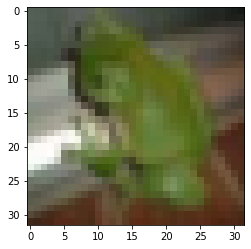

In [8]:
plt.imshow(x_test[7, :])
plt.show()

In [9]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


x_train_ = x_train.astype('float32') / 255.
x_test_ = x_test.astype('float32') / 255.


x_train_ = x_train_.reshape(-1, w_dim * h_dim * c_dim)
x_test_ = x_test_.reshape(-1, w_dim * h_dim * c_dim)

In [10]:
x_train_[0]

array([0.23137255, 0.24313726, 0.24705882, ..., 0.48235294, 0.36078432,
       0.28235295], dtype=float32)

In [11]:
x_train_.shape

(50000, 3072)

In [12]:
y_test.shape

(10000, 10)

## Определение Encoder / decoder 

**Задание 2**  Ниже приведен код, который  определяет энкодер и декодер, и реализуйт выборку с приемом репараметризации в предоставленном пространстве.

In [13]:
master_batch_size = 100
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim], name = 'Inpute_encoder'))
   # encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    # encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder'))
    # encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder'))
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim], name = 'Inpute_decoder'))
    # decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder'))
    # decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder'))
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


In [14]:
def vlb_binomial(x, x_decoded_mean,  x_decoded_var, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    #cce = tf.keras.losses.CategoricalCrossentropy(axis=1)
    t_var =  tf.exp(t_log_var)
    kl = -t_log_var/2.0 + (t_var + t_mean**2 - 1)/2.0
    kl = tf.reduce_sum(kl, axis=1)
    batch_size = x.shape[0]
    number_of_pixels = x.shape[1]
    latend_dim = t_mean.shape[1]

    two_pi = tf.constant(2.0 * np.pi)      
    #log_p = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)                                                                                                                        
    #log_p = -number_of_pixels/ 2.0 * tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-6) -  tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) / (2.0 * tf.math.pow(x_decoded_var, 2.0)  + 1.0 * 1e-6)
    log_p = -0.5 * (tf.math.log(two_pi) + tf.math.log(x_decoded_var + 1e-6) + tf.math.log(x_decoded_var + 1e-6) +  tf.math.divide_no_nan(tf.math.pow(tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0), 2.0) , tf.math.pow(x_decoded_var, 2.0)) + 1.0 * 1e-6)
    log_p = tf.reduce_sum(log_p, axis=1) 

    #result = tf.reduce_mean(number_of_pixels*log_p - kl) 
    result = tf.reduce_mean(log_p - kl) #* (x_train_.shape[0] / master_batch_size )
    
    print("batch_size = {}, number_of_pixels = {} kl_size = {}".format(batch_size, number_of_pixels, kl.shape))
    return tf.math.multiply_no_nan(result, tf.constant([-1.0]))

## Обучение модели

**Задание 3** Запустите указанные ниже ячейки, чтобы обучить модель с настройками по умолчанию. Измените параметры, чтобы получить лучшие результаты. Особенно обратите внимание на архитектуру кодировщика/декодера (например, использование большего количества слоев, возможно, сделав их сверточными), скорость обучения и количество эпох.

batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


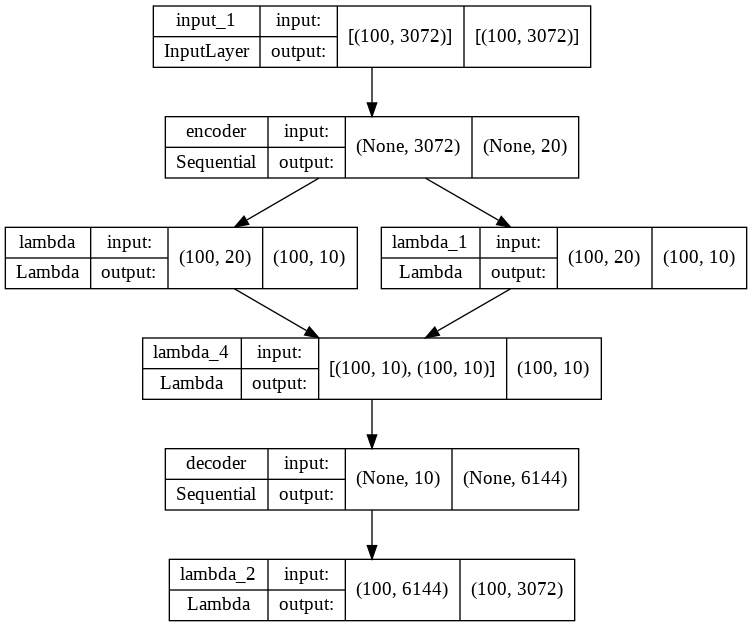

In [15]:
loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae,show_shapes = True)

In [16]:
# hist = cvae.fit(x=[x_train_, y_train],
#                 y=[x_train_, y_train],
#                 shuffle=True,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 validation_data=([x_test_, y_test], [x_test_,  y_test]),
#                 verbose=2)

# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: loss)
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
#                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'

hist = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=20,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])

vae.load_weights(save_filepath)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
48800/50000 [============================>.] - ETA: 0s - loss: 9175.8925

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 7394.65897, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 8s 161us/sample - loss: 9138.5556 - val_loss: 7394.6590
Epoch 2/20
49700/50000 [============================>.] - ETA: 0s - loss: 6995.3296
Epoch 2: val_loss improved from 7394.65897 to 6783.58581, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 79us/sample - loss: 6992.2467 - val_loss: 6783.5858
Epoch 3/20
49500/50000 [============================>.] - ETA: 0s - loss: 6601.7478
Epoch 3: val_loss improved from 6783.58581 to 6479.86797, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 75us/sample - loss: 6600.9549 - val_loss: 6479.8680
Epoch 4/20
48800/50000 [===========================

In [17]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
del vae

# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [18]:
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim], name = 'Inpute_encoder'))
   # encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    # encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder'))
    # encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder'))
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim], name = 'Inpute_decoder'))
    # decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder'))
    # decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder'))
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


In [19]:


loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'
vae.load_weights(save_filepath)
hist2 = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=30,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])
vae.load_weights(save_filepath)


batch_size = 100, number_of_pixels = 3072 kl_size = (100,)
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49900/50000 [============================>.] - ETA: 0s - loss: 6167.7044

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 6092.85917, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 77us/sample - loss: 6167.1071 - val_loss: 6092.8592
Epoch 2/30
48700/50000 [============================>.] - ETA: 0s - loss: 6069.2864
Epoch 2: val_loss improved from 6092.85917 to 6076.39586, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 71us/sample - loss: 6066.4890 - val_loss: 6076.3959
Epoch 3/30
49400/50000 [============================>.] - ETA: 0s - loss: 6053.7219
Epoch 3: val_loss improved from 6076.39586 to 6075.10499, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 77us/sample - loss: 6053.6565 - val_loss: 6075.1050
Epoch 4/30
50000/50000 [============================

### Визуализация реконструкции для обучения и проверки данных
На рисунке ниже вы можете увидеть способность вашей сети к реконструкции на основе данных обучения и валидации. В каждом из двух изображений левый столбец — это изображения CIFAR, а правый столбец — это соответствующее изображение после прохождения через автоэнкодер (или, точнее, среднее значение биномиального распределения по выходным изображениям).

Обратите внимание, что получение наилучшей возможной реконструкции не является целью VAE, дивергенция Кульбака-Лейблера KL функции потерь ухудшает производительность реконструкции. Но реконструкция в любом случае должна быть разумной, и они предоставляют визуальный инструмент отладки кода.

In [20]:
x_decoded_mean = vae.get_layer('decoder')


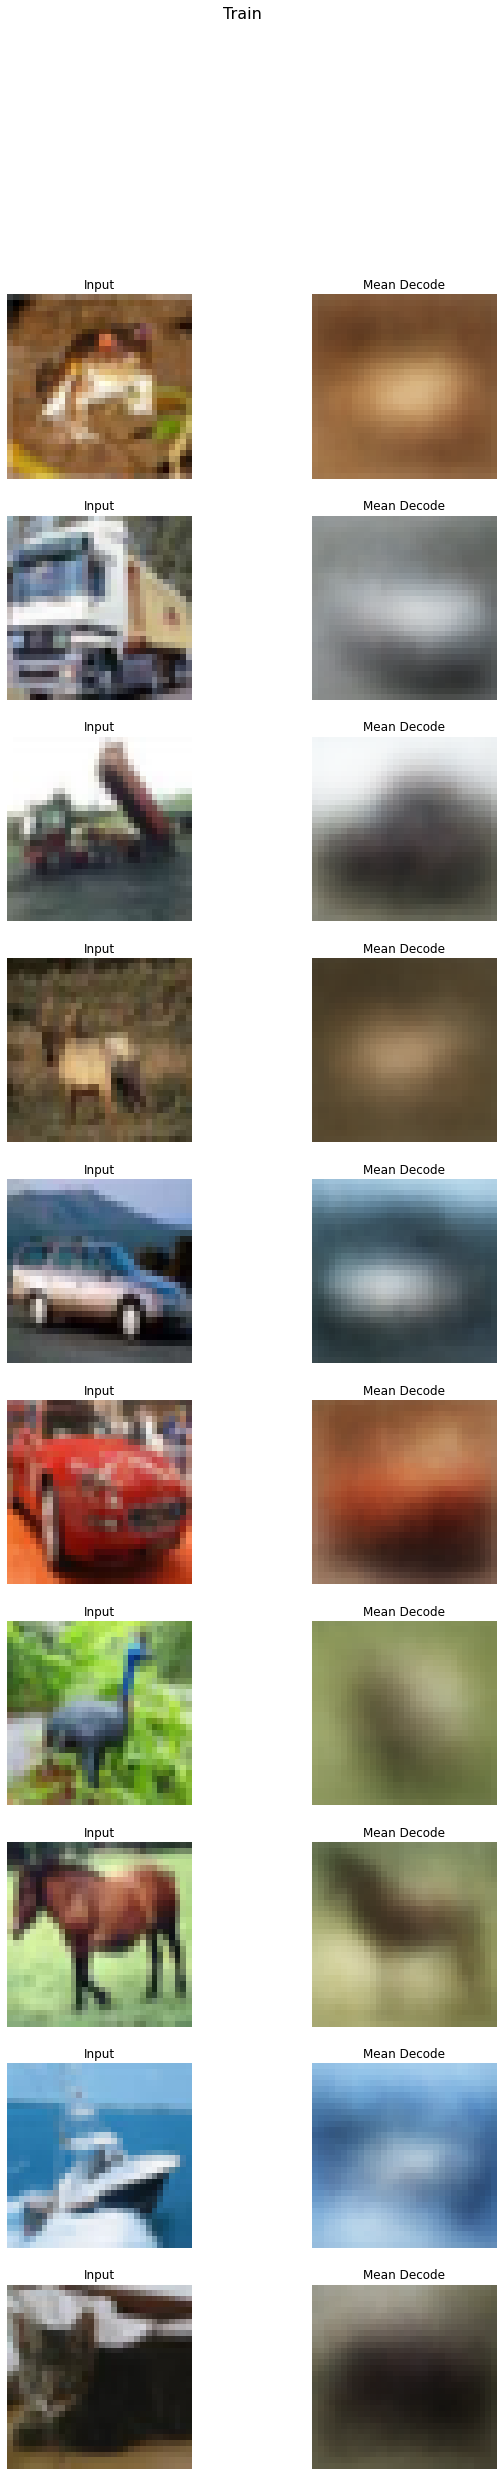

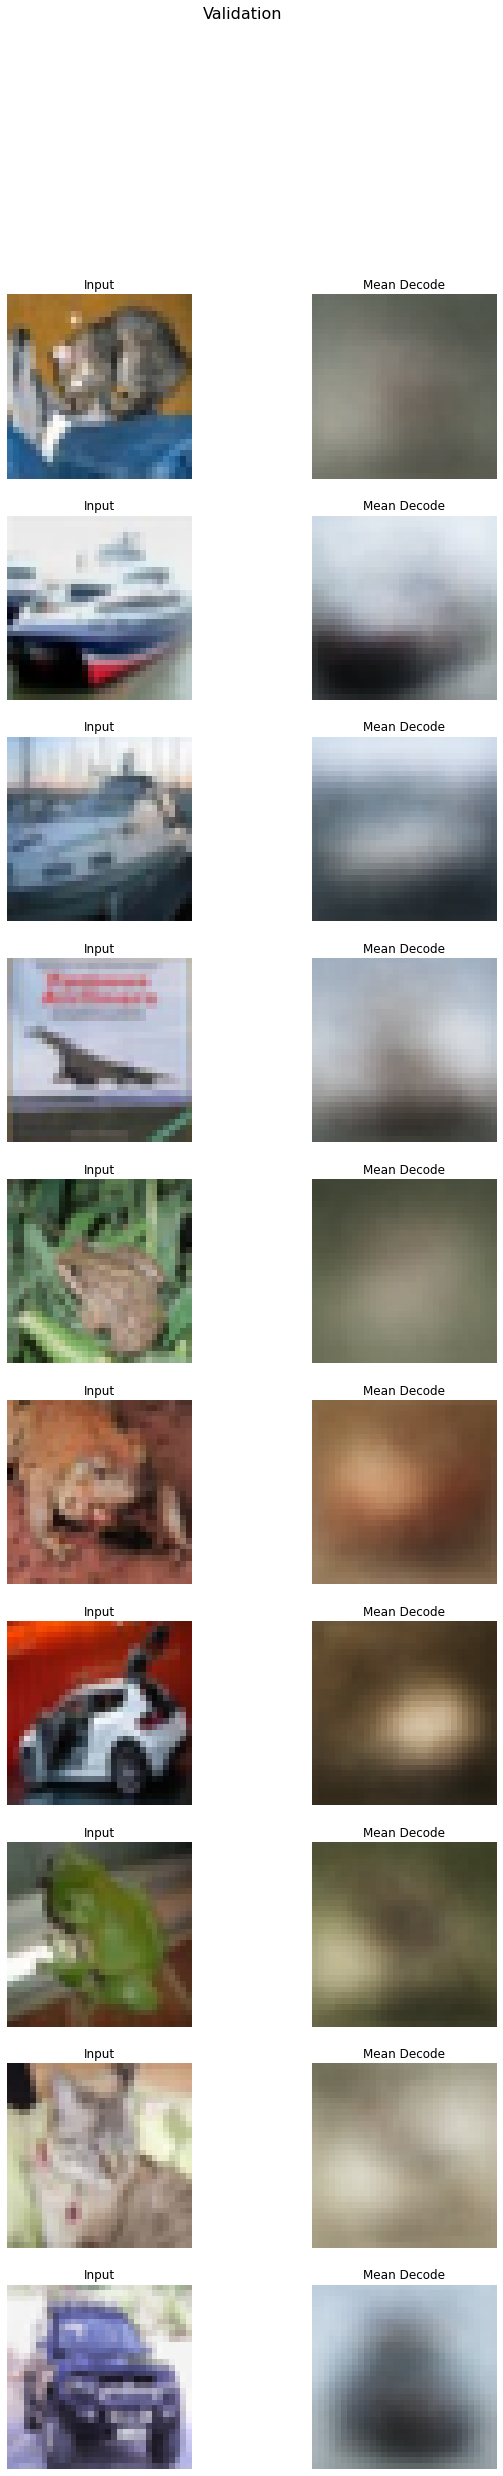

In [21]:

for fid_idx, (data, title) in enumerate(zip([x_train_, x_test_]
                                          , ['Train', 'Validation'])
                                        ):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(get_x_mean(x_decoded), feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

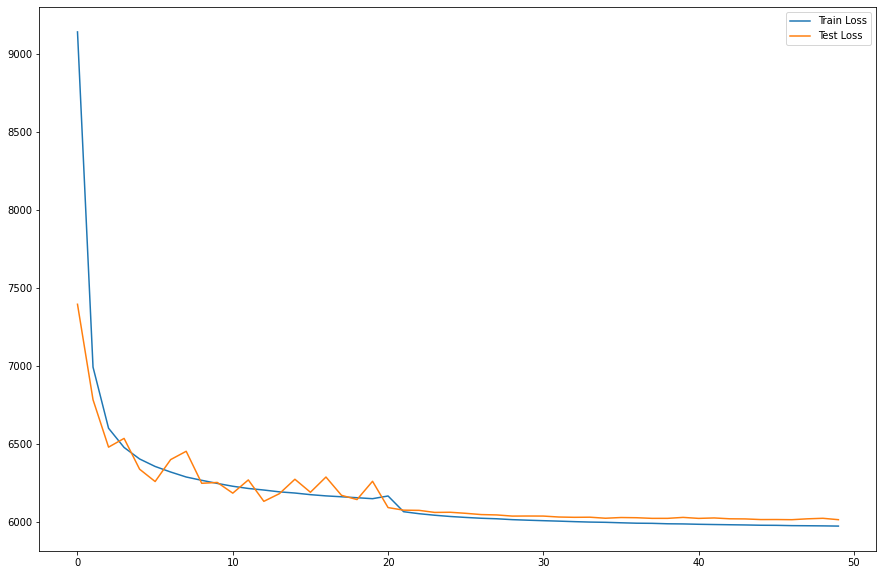

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss = np.concatenate([hist.history['loss'], hist2.history['loss']])

plt.plot(train_loss, label = 'Train Loss')


test_loss = np.concatenate([hist.history['val_loss'], hist2.history['val_loss']])

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


## Варьирование параметров модели

Проварьируем структуру модели, добавив промежуточных слоев энкодера и декода, естественно прежде увеличив размерность параметров.

In [23]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()


# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [24]:
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 1024 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim], name = 'Inpute_encoder'))
    encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder')) #ADDITION LAYER
    encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder')) #ADDITION LAYER
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim], name = 'Inpute_decoder'))
    decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder')) #ADDITION LAYER
    decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder')) #ADDITION LAYER
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


Instructions for updating:
Colocations handled automatically by placer.


batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


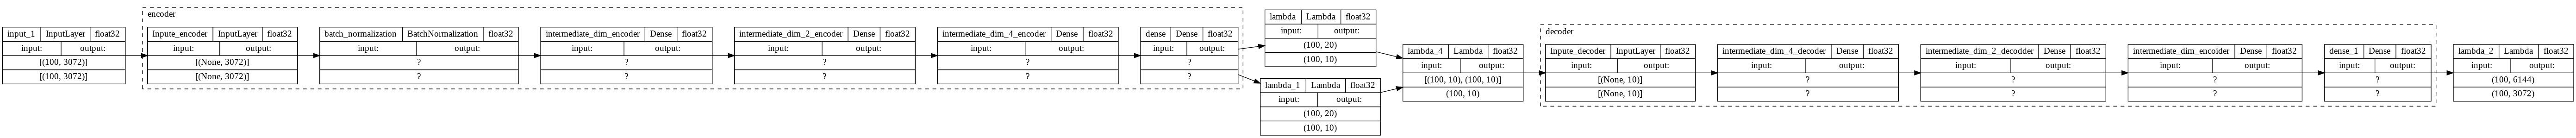

In [25]:

loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae,show_shapes = True,  
    show_dtype=True,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,

    show_layer_activations=True
)

In [26]:



vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'

hist3 = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=50,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])
vae.load_weights(save_filepath)


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
49700/50000 [============================>.] - ETA: 0s - loss: 7532.0641

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 6603.53995, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 8s 150us/sample - loss: 7526.6182 - val_loss: 6603.5399
Epoch 2/50
49600/50000 [============================>.] - ETA: 0s - loss: 6471.7983
Epoch 2: val_loss improved from 6603.53995 to 6202.09325, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 7s 133us/sample - loss: 6471.2849 - val_loss: 6202.0933
Epoch 3/50
49500/50000 [============================>.] - ETA: 0s - loss: 6290.0885
Epoch 3: val_loss did not improve from 6202.09325
50000/50000 [==============================] - 4s 86us/sample - loss: 6292.1583 - val_loss: 6379.3860
Epoch 4/50
49900/50000 [============================>.] - ETA: 0s - loss: 6247.2400
Epoch 4: val_loss improved from 6202.09325 to 6118.53928, saving model to /t

### Визуализация реконструкции для обучения и проверки данных
На рисунке ниже вы можете увидеть способность вашей сети к реконструкции на основе данных обучения и валидации. В каждом из двух изображений левый столбец — это изображения CIFAR, а правый столбец — это соответствующее изображение после прохождения через автоэнкодер (или, точнее, среднее значение биномиального распределения по выходным изображениям).

Обратите внимание, что получение наилучшей возможной реконструкции не является целью VAE, дивергенция Кульбака-Лейблера KL функции потерь ухудшает производительность реконструкции. Но реконструкция в любом случае должна быть разумной, и они предоставляют визуальный инструмент отладки кода.

In [27]:
x_decoded_mean = vae.get_layer('decoder')


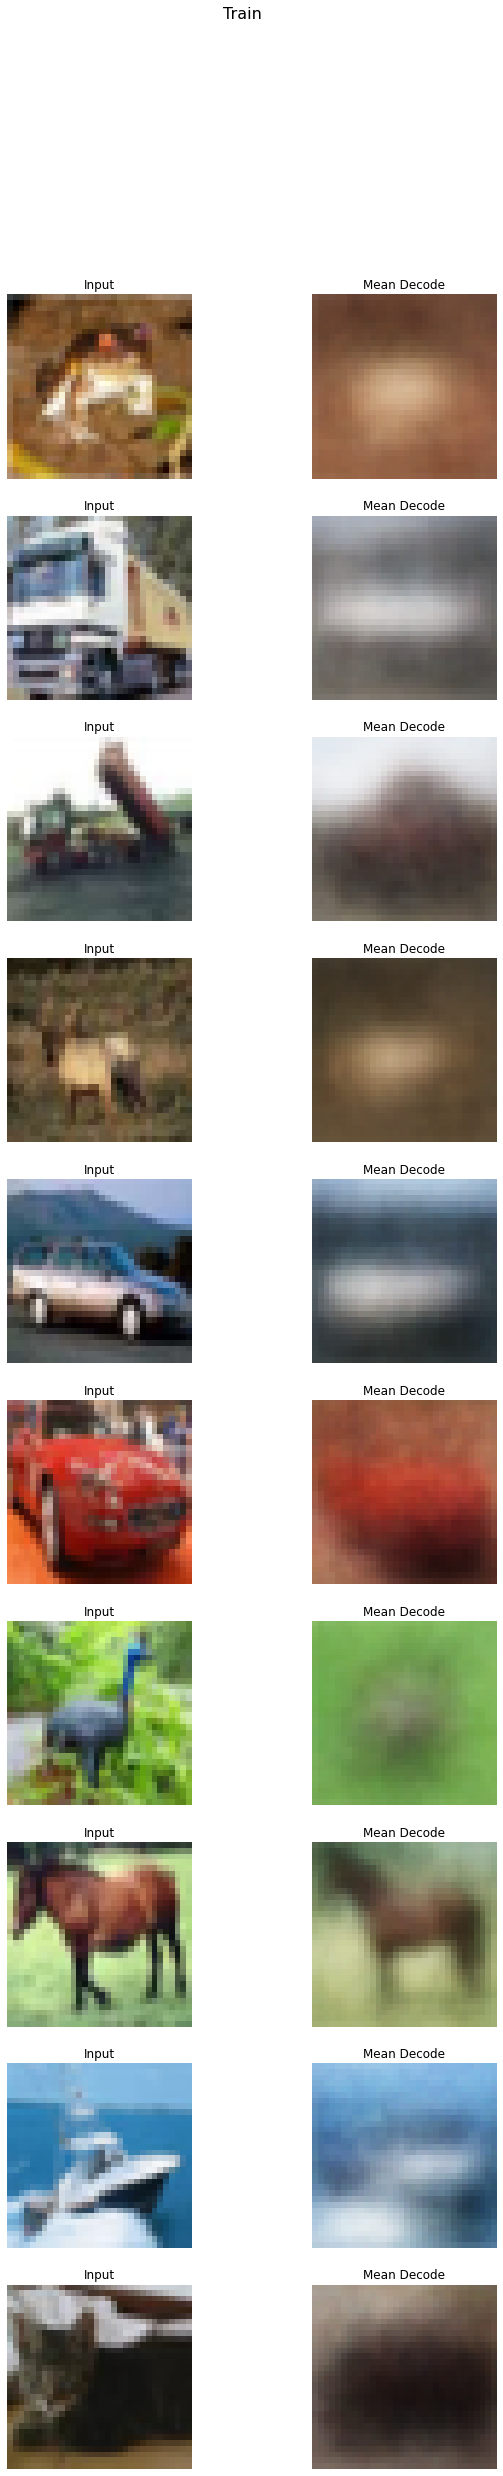

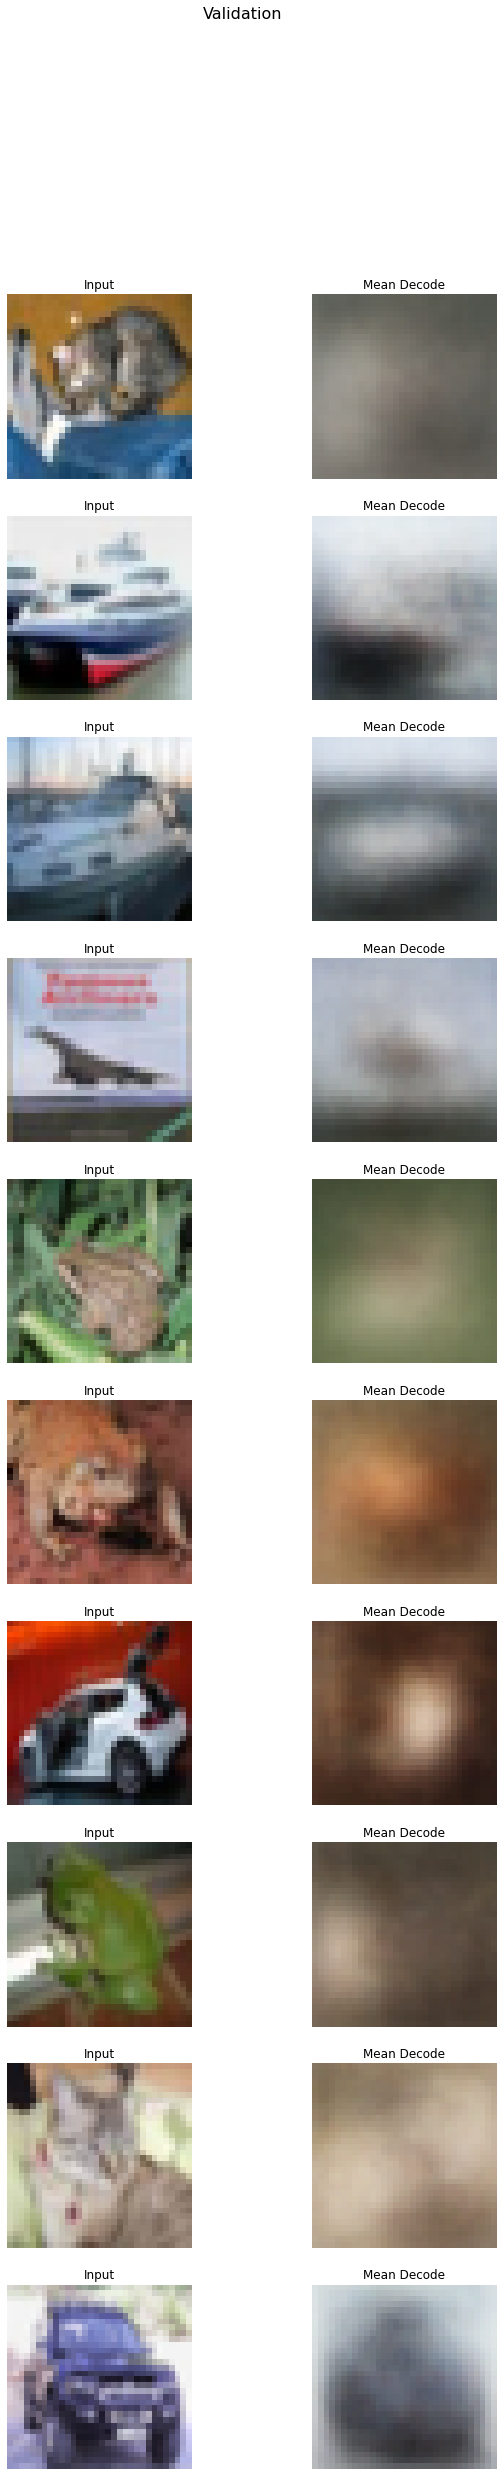

In [28]:

for fid_idx, (data, title) in enumerate(zip([x_train_, x_test_]
                                          , ['Train', 'Validation'])
                                        ):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(get_x_mean(x_decoded), feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

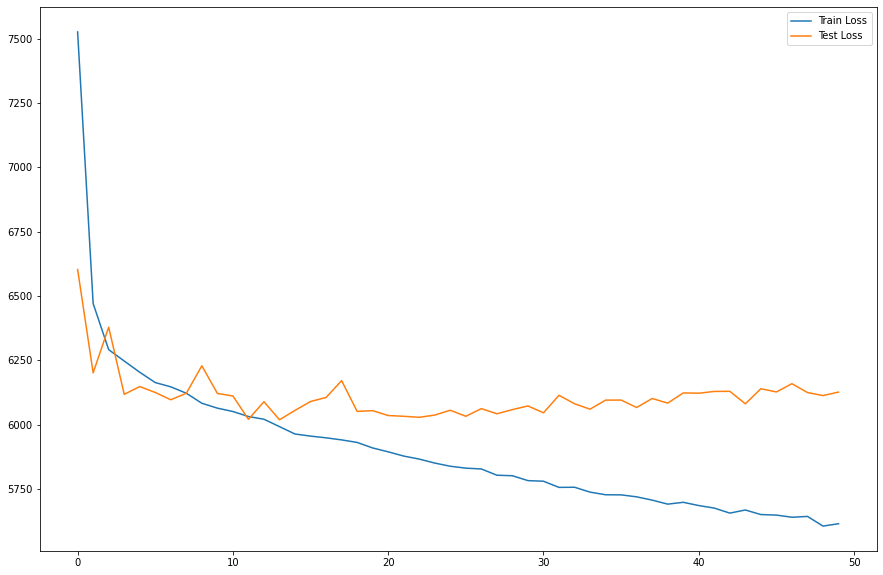

In [29]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss = hist3.history['loss']

plt.plot(train_loss, label = 'Train Loss')


test_loss = hist3.history['val_loss']

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


#### Добавим регулерезацию 

Как видно по графику ошибки, параметров стало достаточно для переобучения.

Однако, субъективное восприятие качества изображений говорит о том, что добавление слоев пошло на пользу.

Для борьбы с переобучением добавим DropOut

In [30]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
del vae
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [31]:
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 1024 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim], name = 'Inpute_encoder'))
    encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    encoder.add(Dropout(0.25))
    encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder')) #ADDITION LAYER
    encoder.add(Dropout(0.25))
    encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder')) #ADDITION LAYER
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim], name = 'Inpute_decoder'))
    decoder.add(Dropout(0.25))
    decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder')) #ADDITION LAYER
    decoder.add(Dropout(0.25))
    decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder')) #ADDITION LAYER
    decoder.add(Dropout(0.25))
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


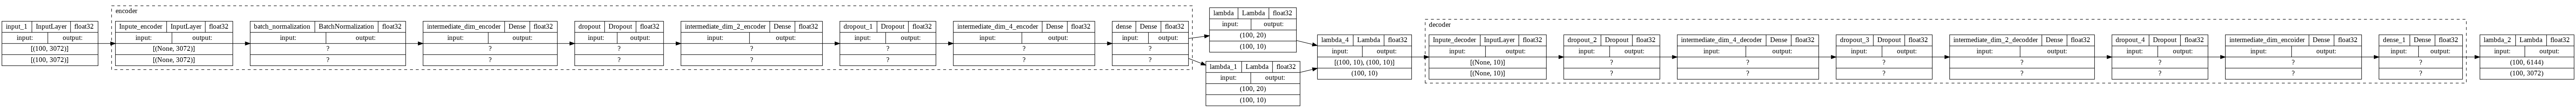

In [32]:

loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae,show_shapes = True,  
    show_dtype=True,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,

    show_layer_activations=True
)

In [33]:



vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'

hist4 = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=50,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])
vae.load_weights(save_filepath)


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
49600/50000 [============================>.] - ETA: 0s - loss: 8968.5968

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 7882.12779, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 11s 215us/sample - loss: 8960.8380 - val_loss: 7882.1278
Epoch 2/50
49700/50000 [============================>.] - ETA: 0s - loss: 8067.9595
Epoch 2: val_loss improved from 7882.12779 to 7640.38690, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 10s 197us/sample - loss: 8067.7224 - val_loss: 7640.3869
Epoch 3/50
49800/50000 [============================>.] - ETA: 0s - loss: 7904.0725
Epoch 3: val_loss improved from 7640.38690 to 7501.17377, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 10s 206us/sample - loss: 7904.0585 - val_loss: 7501.1738
Epoch 4/50
49800/50000 [======================

### Визуализация реконструкции для обучения и проверки данных
На рисунке ниже вы можете увидеть способность вашей сети к реконструкции на основе данных обучения и валидации. В каждом из двух изображений левый столбец — это изображения CIFAR, а правый столбец — это соответствующее изображение после прохождения через автоэнкодер (или, точнее, среднее значение биномиального распределения по выходным изображениям).

Обратите внимание, что получение наилучшей возможной реконструкции не является целью VAE, дивергенция Кульбака-Лейблера KL функции потерь ухудшает производительность реконструкции. Но реконструкция в любом случае должна быть разумной, и они предоставляют визуальный инструмент отладки кода.

In [34]:
x_decoded_mean = vae.get_layer('decoder')


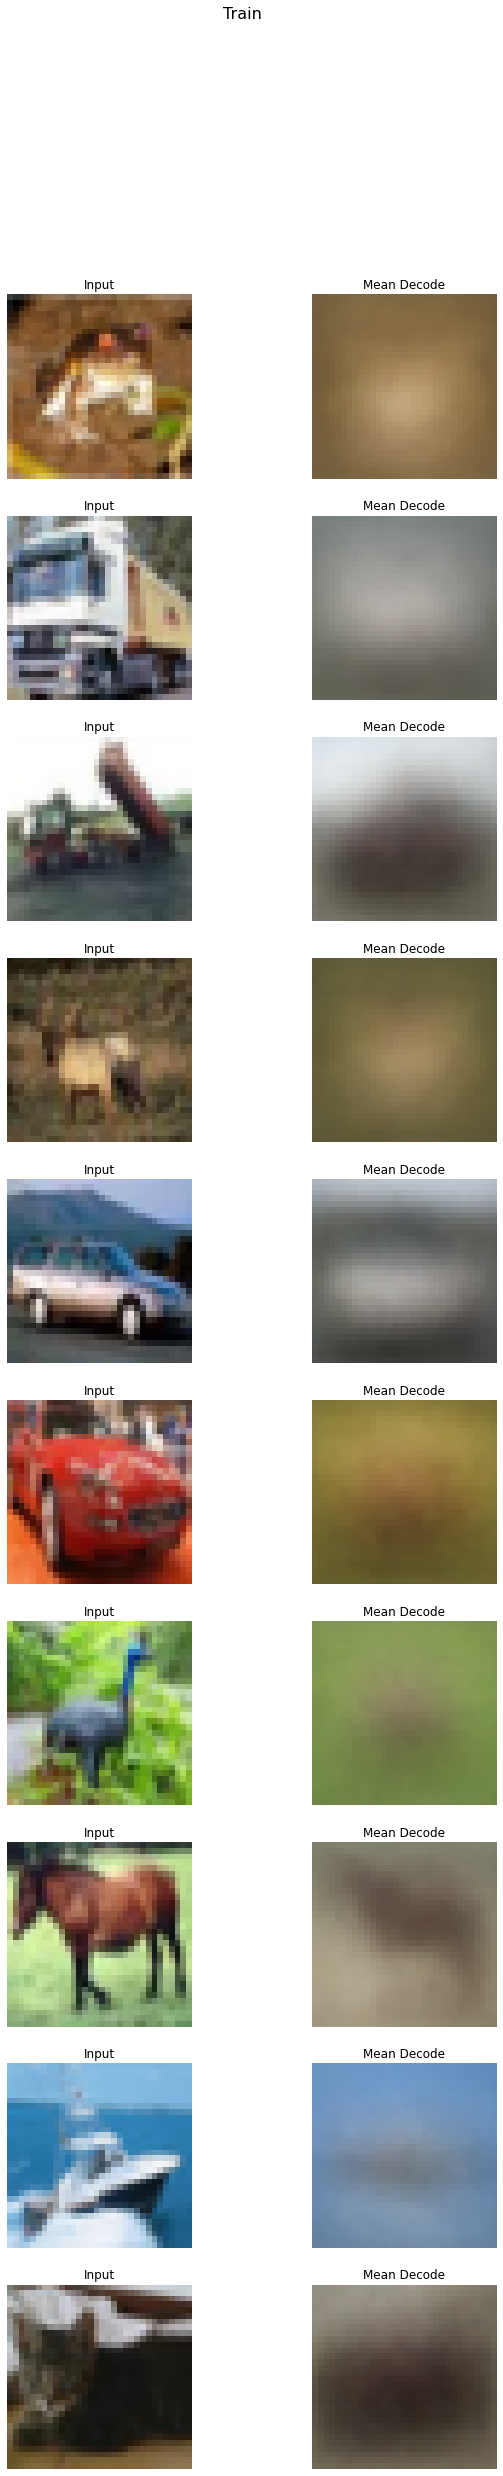

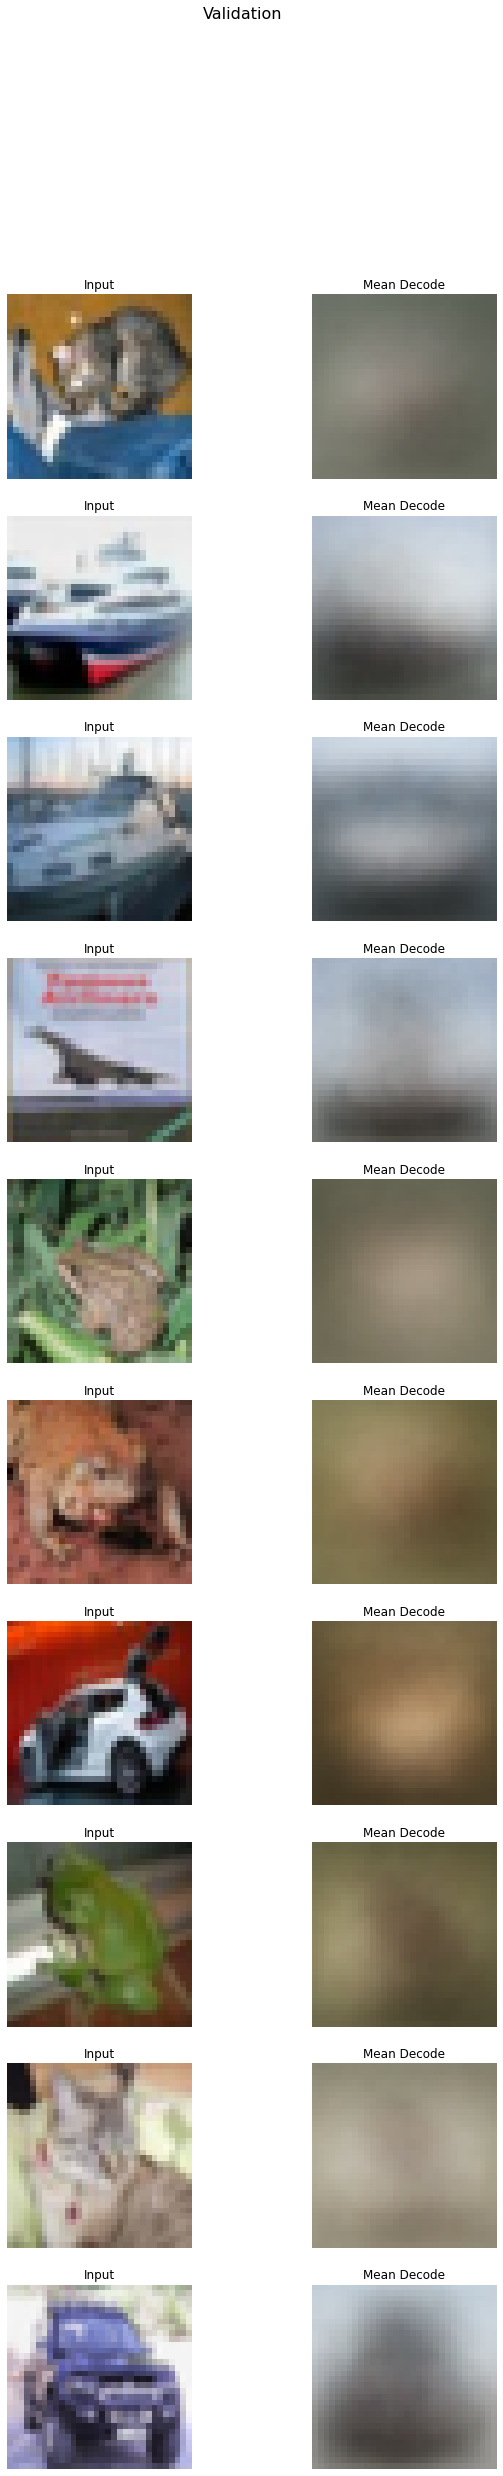

In [35]:

for fid_idx, (data, title) in enumerate(zip([x_train_, x_test_]
                                          , ['Train', 'Validation'])
                                        ):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(get_x_mean(x_decoded), feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

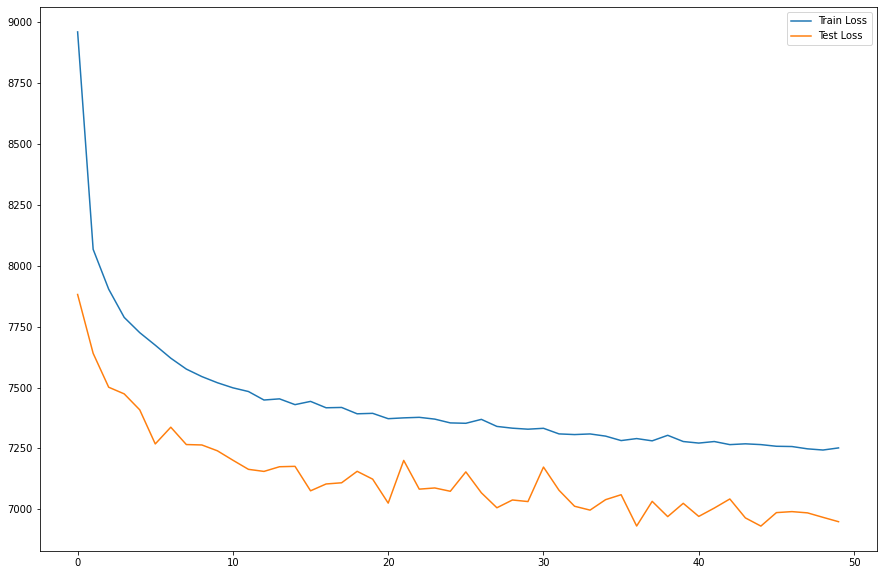

In [36]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss =  hist4.history['loss']

plt.plot(train_loss, label = 'Train Loss')


test_loss =  hist4.history['val_loss']

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


### Метод оптимизации

Судя по графику функции ошибки, переобучение было пресечено, но из-за роста пространства параметров столкнулись со следующей проблемой - локальный минимум, из-за которого показатели сильно ухудшились.

Для борьбы с этим заменим метод оптимизации Adam на AdaBelief, [который имеет наилучшие показатели](https://juntang-zhuang.github.io/adabelief/)  на протяжении обучения.

Для исследования поведения алгоритма оптимизации, уберем DropOut

In [37]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.6 MB/s 


In [38]:
import tensorflow_addons as tfa

In [39]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
del vae
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [40]:
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 1024 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim], name = 'Inpute_encoder'))
    encoder.add(BatchNormalization())
   # encoder.add(Dropout(0.25))
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    
    encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder')) #ADDITION LAYER

    encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder')) #ADDITION LAYER
   
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim], name = 'Inpute_decoder'))
  
    decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder')) #ADDITION LAYER
    decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder')) #ADDITION LAYER

    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    #decoder.add(Dropout(0.25))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


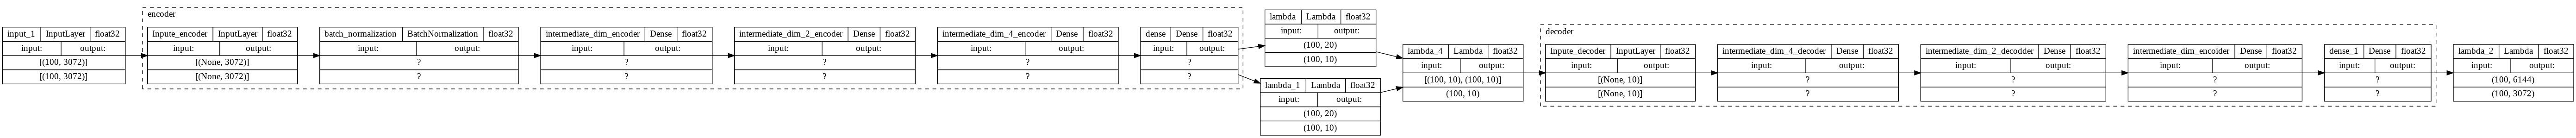

In [41]:

loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae,show_shapes = True,  
    show_dtype=True,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,

    show_layer_activations=True
)

In [42]:



vae.compile(optimizer=tfa.optimizers.AdaBelief(learning_rate=0.2e-3), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'

hist5 = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=50,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])
vae.load_weights(save_filepath)


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
49800/50000 [============================>.] - ETA: 0s - loss: 9944.3784

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 6889.27845, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 19s 371us/sample - loss: 9932.4236 - val_loss: 6889.2784
Epoch 2/50
50000/50000 [==============================] - ETA: 0s - loss: 6550.7414
Epoch 2: val_loss improved from 6889.27845 to 6342.05006, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 14s 282us/sample - loss: 6550.7414 - val_loss: 6342.0501
Epoch 3/50
49900/50000 [============================>.] - ETA: 0s - loss: 6366.9094
Epoch 3: val_loss improved from 6342.05006 to 6276.95335, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 12s 234us/sample - loss: 6366.8581 - val_loss: 6276.9534
Epoch 4/50
50000/50000 [======================

### Визуализация реконструкции для обучения и проверки данных
На рисунке ниже вы можете увидеть способность вашей сети к реконструкции на основе данных обучения и валидации. В каждом из двух изображений левый столбец — это изображения CIFAR, а правый столбец — это соответствующее изображение после прохождения через автоэнкодер (или, точнее, среднее значение биномиального распределения по выходным изображениям).

Обратите внимание, что получение наилучшей возможной реконструкции не является целью VAE, дивергенция Кульбака-Лейблера KL функции потерь ухудшает производительность реконструкции. Но реконструкция в любом случае должна быть разумной, и они предоставляют визуальный инструмент отладки кода.

In [43]:
x_decoded_mean = vae.get_layer('decoder')


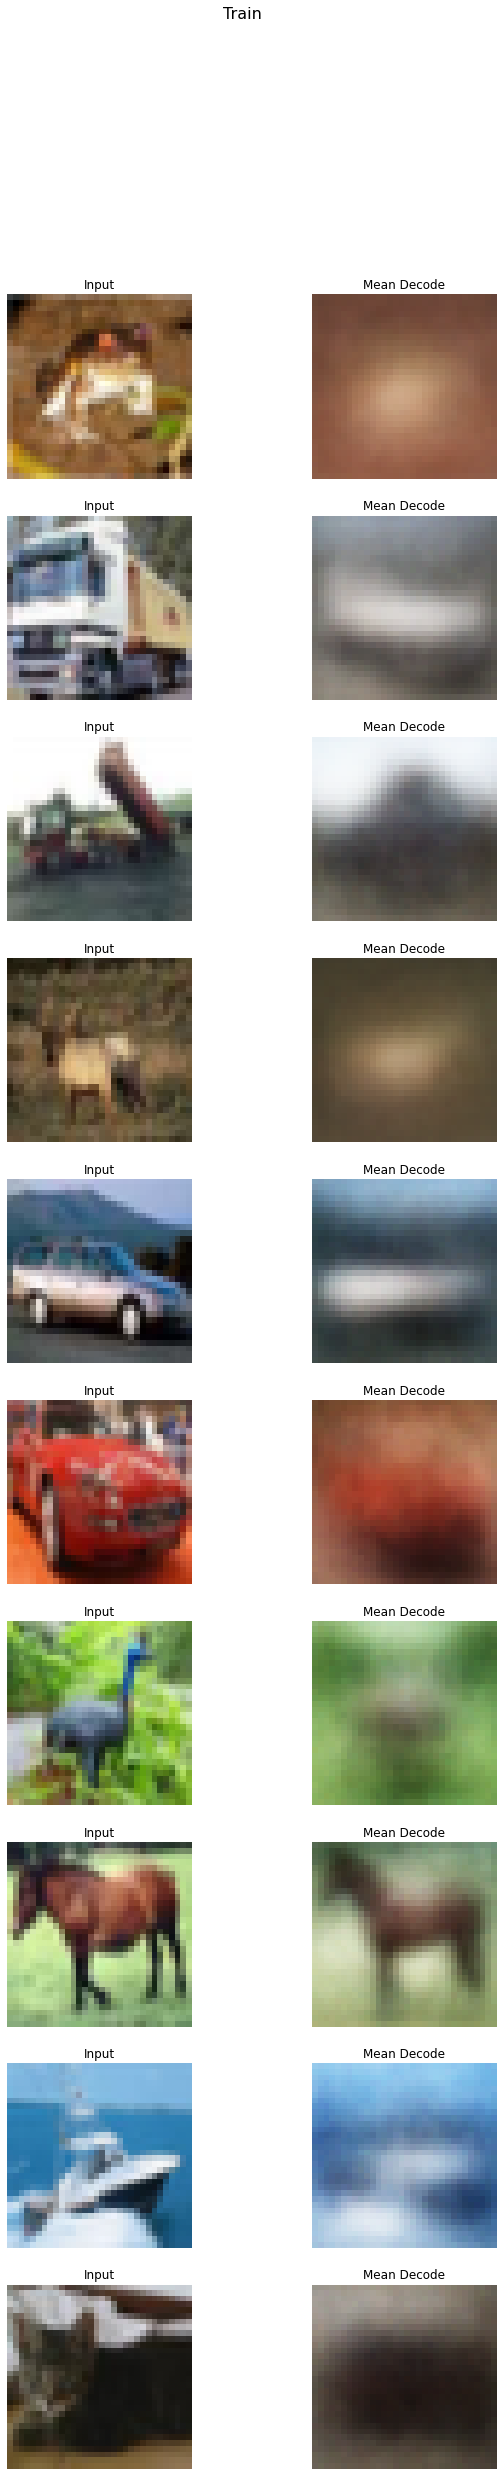

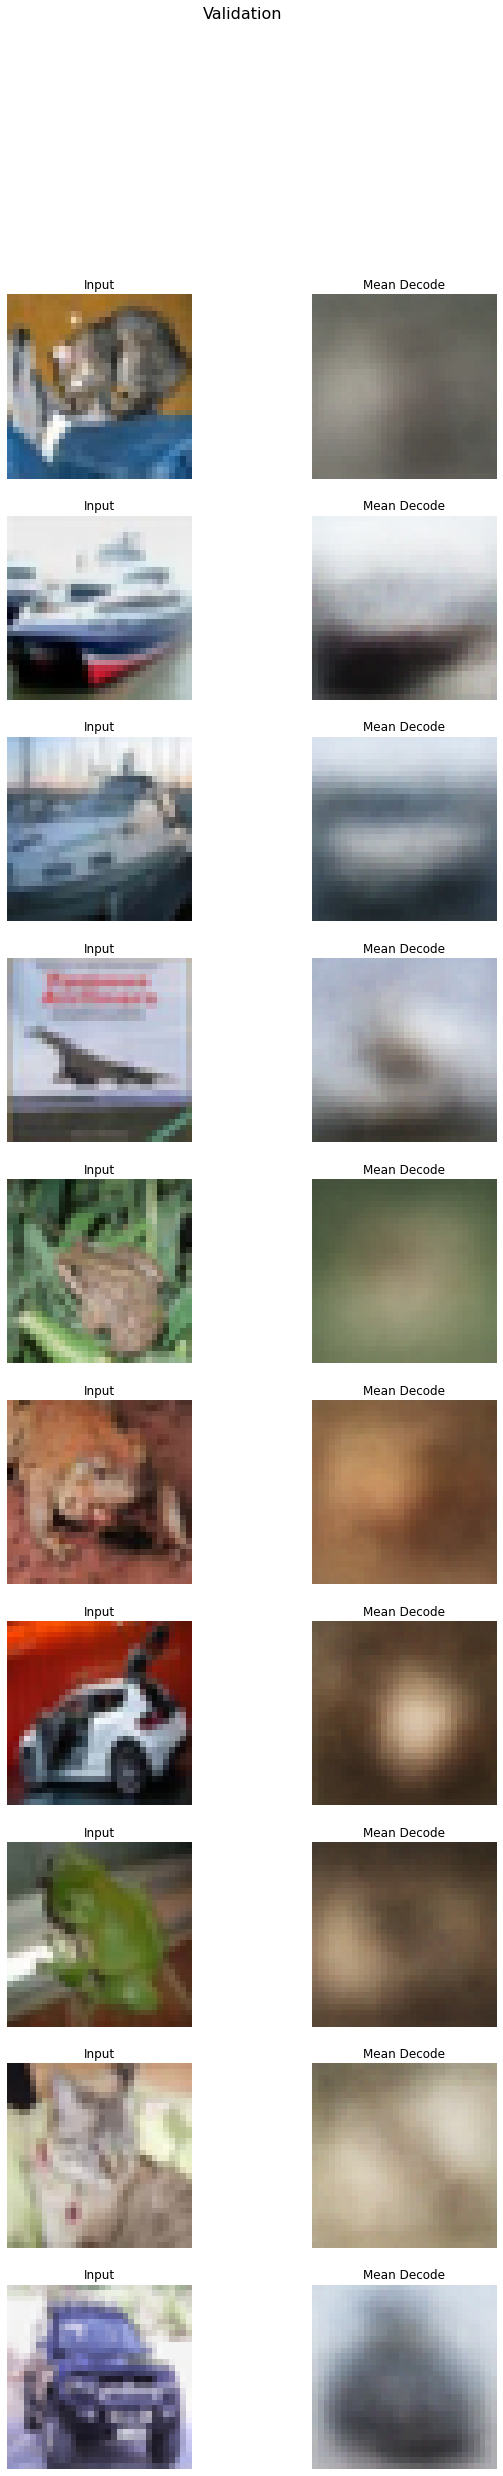

In [44]:

for fid_idx, (data, title) in enumerate(zip([x_train_, x_test_]
                                          , ['Train', 'Validation'])
                                        ):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(get_x_mean(x_decoded), feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

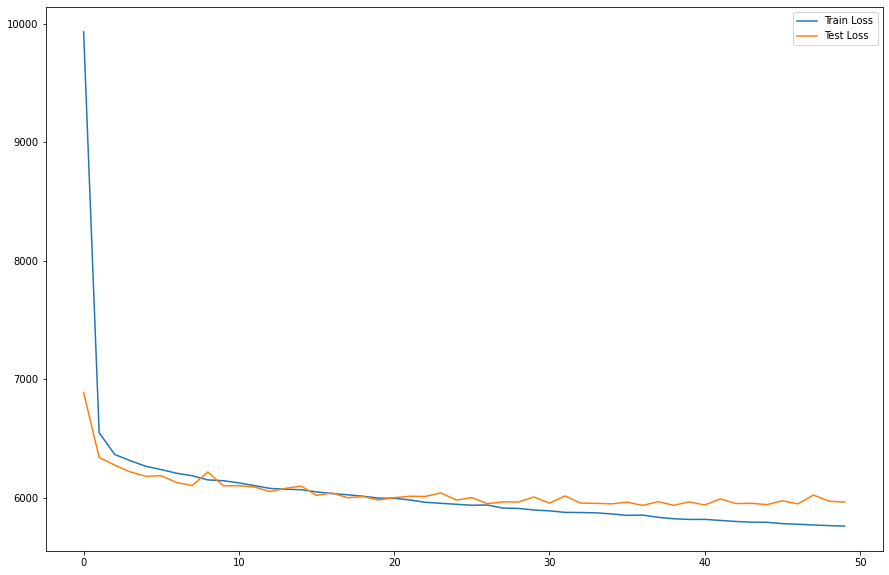

In [45]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss =  hist5.history['loss']

plt.plot(train_loss, label = 'Train Loss')


test_loss = hist5.history['val_loss']

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


## Создание новых данных
**Задание 4** Написать код для создания новых образцов изображений из обученного VAE. Для этого нужно выбрать из априорного распределения $p(t)$, а затем из вероятности $p(x \mid t)$.

**Обратите внимание**, что выборка, которую вы записали в Задаче 2, относится к вариационному распределению $q(t \mid x)$, а здесь вам нужно взять исходную выборку.

In [46]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.
# ...
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
_mean = tf.zeros([n_samples, original_dim], dtype=tf.float32)
_std =tf.ones([n_samples, original_dim], dtype=tf.float32)
t_samples = tf.random.normal([n_samples, latent_dim], mean=0, stddev=1, dtype=tf.float32)
sampled_im_mean = get_x_mean(decoder(t_samples))

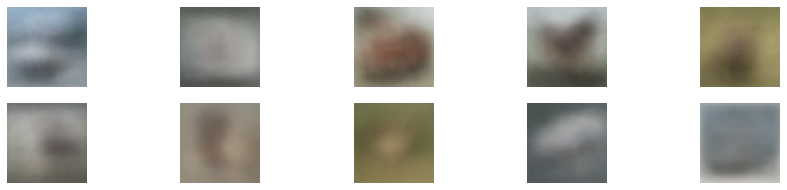

In [47]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure(figsize = (15, 5))
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(w_dim, h_dim, c_dim))
    ax.axis('off')
plt.show()

## Задача 5


**Задача 5.1** Здесь будет повторно внедрен CVAE модель, т.е. будут использованы  ```create_encoder``` и ```create_decoder```, определенные ранее (теперь вы можете понять, почему они принимают размер ввода в качестве аргумента ;) ). также будет использоваться слой Keras `concatenate` для объединения меток с входными данными и скрытым кодом.


In [48]:
from keras.datasets import cifar10
from PIL import Image
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
w_dim = x_train[0].shape[0]
h_dim = x_train[0].shape[1]
c_dim = x_train[0].shape[2]

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


x_train_ = x_train.astype('float32') / 255.
x_test_ = x_test.astype('float32') / 255.


x_train_ = x_train_.reshape(-1, w_dim * h_dim * c_dim)
x_test_ = x_test_.reshape(-1, w_dim * h_dim * c_dim)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
del vae

# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [49]:
batch_size = master_batch_size
original_dim = x_train_.shape[1] # Number of pixels in  images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 200


x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

def create_encoder2(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder2 = Sequential(name='encoder2')
    encoder2.add(InputLayer([input_dim], name = 'Inpute_encoder'))
   # encoder.add(BatchNormalization())
    encoder2.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoder'))
    # encoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_encoder'))
    # encoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_encoder'))
    encoder2.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder2

    


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])

encoder2 = create_encoder2(original_dim + 10)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
get_x =  Lambda(lambda h: h[:, :original_dim])
h = encoder2(tf.concat([x,label], 1))
cond_t_mean = get_t_mean(h)
cond_t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

def create_decoder2(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder2 = Sequential(name='decoder2')
    decoder2.add(InputLayer([input_dim], name = 'Inpute_decoder2'))
    # decoder.add(Dense(intermediate_dim // 4, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_4_decoder'))
    # decoder.add(Dense(intermediate_dim // 2, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_2_decodder'))
    decoder2.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(), name = 'intermediate_dim_encoider'))
    decoder2.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder2









    
decoder2 = create_decoder2(latent_dim + 10)
cond_x_decoded = decoder2(tf.concat([t,label] ,1))
cond_x_decoded_mean = get_x_mean(cond_x_decoded)
cond_x_decoded_var = get_x_var(cond_x_decoded)



In [50]:
def vlb_binomial(x, x_decoded_mean,  x_decoded_var, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    #cce = tf.keras.losses.CategoricalCrossentropy(axis=1)
    t_var =  tf.exp(t_log_var)
    kl = -t_log_var/2.0 + (t_var + t_mean**2 - 1)/2.0
    kl = tf.reduce_sum(kl, axis=1)
    batch_size = x.shape[0]
    number_of_pixels = x.shape[1]
    latend_dim = t_mean.shape[1]

    two_pi = tf.constant(2.0 * np.pi)      
    #log_p = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)                                                                                                                        
    #log_p = -number_of_pixels/ 2.0 * tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-6) -  tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) / (2.0 * tf.math.pow(x_decoded_var, 2.0)  + 1.0 * 1e-6)
    log_p = -0.5 * (tf.math.log(two_pi) + tf.math.log(x_decoded_var + 1e-6) + tf.math.log(x_decoded_var + 1e-6) +  tf.math.divide_no_nan(tf.math.pow(tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0), 2.0) , tf.math.pow(x_decoded_var, 2.0)) + 1.0 * 1e-6)
    log_p = tf.reduce_sum(log_p, axis=1) 

    #result = tf.reduce_mean(number_of_pixels*log_p - kl) 
    result = tf.reduce_mean(log_p - kl) #* (x_train_.shape[0] / master_batch_size )
    
    print("batch_size = {}, number_of_pixels = {} kl_size = {}".format(batch_size, number_of_pixels, kl.shape))
    return -result

## Определение функции ошибки и модели

batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


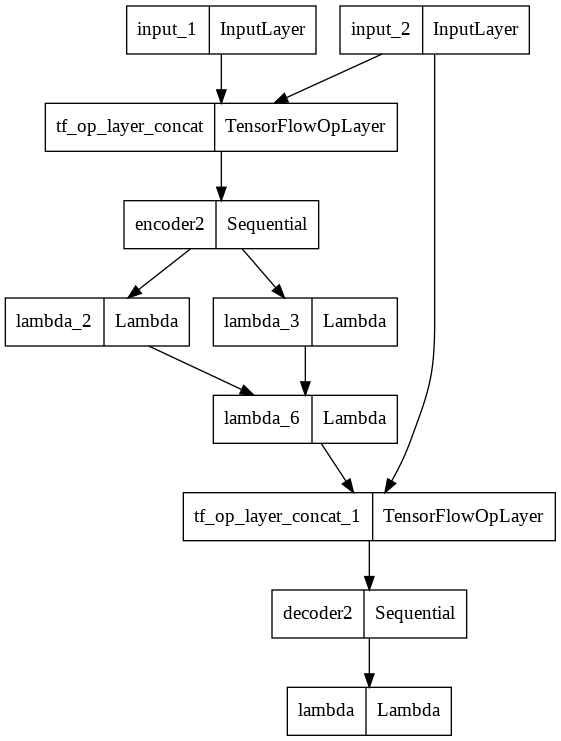

In [51]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean , cond_x_decoded_var, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean )
cvae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: conditional_loss)
#cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
#                amsgrad=False, name='Adam'), loss=lambda x, y: loss)
tf.keras.utils.plot_model(cvae)

### Обучение модели

In [52]:
save_filepath = '/tmp_cifar/checkpoint'

hist = cvae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 10)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])



Train on 50000 samples, validate on 10000 samples
Epoch 1/200
49900/50000 [============================>.] - ETA: 0s - loss: 8946.3489

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 7345.56675, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 7s 148us/sample - loss: 8943.0149 - val_loss: 7345.5667
Epoch 2/200
49500/50000 [============================>.] - ETA: 0s - loss: 6896.6295
Epoch 2: val_loss improved from 7345.56675 to 7045.66121, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 7s 134us/sample - loss: 6894.1982 - val_loss: 7045.6612
Epoch 3/200
49800/50000 [============================>.] - ETA: 0s - loss: 6607.6674
Epoch 3: val_loss improved from 7045.66121 to 6431.16943, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 8s 154us/sample - loss: 6606.8590 - val_loss: 6431.1694
Epoch 4/200
49600/50000 [============================>.] - ETA: 0s - loss: 6489.0885
Epoch 4: val_loss did not improve from 6431.16943
50000/50000 [==============================] - 4s 70us/sample - loss: 6489.7677 - val_loss: 6778.8831
Epoch 5/200
49800/50000 [============================>.] - ETA: 0s - loss: 6409.1859
Epoch 5: val_loss did not improve from 6431.16943
50000/50000 [==============================] - 3s 60us/sample - loss: 6409.7048 - val_loss: 6837.7908
Epoch 6/200
49600/50000 [============================>.] - ETA: 0s - loss: 6353.2685
Epoch 6: val_loss improved from 6431.16943 to 6257.61854, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 74us/sample - loss: 6352.4559 - val_loss: 6257.6185
Epoch 7/200
49200/50000 [============================>.] - ETA: 0s - loss: 6306.1421
Epoch 7: val_loss did not improve from 6257.61854
50000/50000 [==============================] - 2s 47us/sample - loss: 6305.4108 - val_loss: 6283.2945
Epoch 8/200
48900/50000 [============================>.] - ETA: 0s - loss: 6278.5253
Epoch 8: val_loss improved from 6257.61854 to 6226.30888, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 74us/sample - loss: 6277.6237 - val_loss: 6226.3089
Epoch 9/200
50000/50000 [==============================] - ETA: 0s - loss: 6249.8790
Epoch 9: val_loss improved from 6226.30888 to 6218.55078, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 76us/sample - loss: 6249.8790 - val_loss: 6218.5508
Epoch 10/200
49800/50000 [============================>.] - ETA: 0s - loss: 6227.5390
Epoch 10: val_loss did not improve from 6218.55078
50000/50000 [==============================] - 2s 46us/sample - loss: 6227.1970 - val_loss: 6578.7377
Epoch 11/200
49000/50000 [============================>.] - ETA: 0s - loss: 6209.9140
Epoch 11: val_loss did not improve from 6218.55078
50000/50000 [==============================] - 2s 46us/sample - loss: 6208.7213 - val_loss: 6279.4094
Epoch 12/200
49500/50000 [============================>.] - ETA: 0s - loss: 6194.7386
Epoch 12: val_loss improved from 6218.55078 to 6189.94103, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 73us/sample - loss: 6194.0680 - val_loss: 6189.9410
Epoch 13/200
49900/50000 [============================>.] - ETA: 0s - loss: 6180.1360
Epoch 13: val_loss did not improve from 6189.94103
50000/50000 [==============================] - 2s 47us/sample - loss: 6180.0774 - val_loss: 6192.0478
Epoch 14/200
49300/50000 [============================>.] - ETA: 0s - loss: 6171.6281
Epoch 14: val_loss did not improve from 6189.94103
50000/50000 [==============================] - 2s 46us/sample - loss: 6171.0426 - val_loss: 6196.8290
Epoch 15/200
49900/50000 [============================>.] - ETA: 0s - loss: 6160.5881
Epoch 15: val_loss improved from 6189.94103 to 6187.08227, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 83us/sample - loss: 6160.4594 - val_loss: 6187.0823
Epoch 16/200
49400/50000 [============================>.] - ETA: 0s - loss: 6149.1516
Epoch 16: val_loss improved from 6187.08227 to 6162.36509, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 76us/sample - loss: 6151.1402 - val_loss: 6162.3651
Epoch 17/200
49600/50000 [============================>.] - ETA: 0s - loss: 6144.7205
Epoch 17: val_loss improved from 6162.36509 to 6124.44613, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 75us/sample - loss: 6143.7724 - val_loss: 6124.4461
Epoch 18/200
49600/50000 [============================>.] - ETA: 0s - loss: 6135.6370
Epoch 18: val_loss improved from 6124.44613 to 6108.57558, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 76us/sample - loss: 6135.8783 - val_loss: 6108.5756
Epoch 19/200
49400/50000 [============================>.] - ETA: 0s - loss: 6127.1454
Epoch 19: val_loss did not improve from 6108.57558
50000/50000 [==============================] - 2s 48us/sample - loss: 6127.3084 - val_loss: 6152.6685
Epoch 20/200
49000/50000 [============================>.] - ETA: 0s - loss: 6120.5087
Epoch 20: val_loss did not improve from 6108.57558
50000/50000 [==============================] - 2s 46us/sample - loss: 6121.1156 - val_loss: 6133.0782
Epoch 21/200
50000/50000 [==============================] - ETA: 0s - loss: 6113.4868
Epoch 21: val_loss did not improve from 6108.57558
50000/50000 [==============================] - 2s 46us/sample - loss: 6113.4868 - val_loss: 6117.8552
Epoch 22/200
49500/50000 [============================>.] - ETA: 0s - loss: 6105.2566
Epoch 22: val_loss did not improve from 6108.57558
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 75us/sample - loss: 6094.9819 - val_loss: 6080.5563
Epoch 25/200
49500/50000 [============================>.] - ETA: 0s - loss: 6089.7031
Epoch 25: val_loss did not improve from 6080.55633
50000/50000 [==============================] - 2s 47us/sample - loss: 6088.9751 - val_loss: 6180.3315
Epoch 26/200
49300/50000 [============================>.] - ETA: 0s - loss: 6082.7319
Epoch 26: val_loss did not improve from 6080.55633
50000/50000 [==============================] - 2s 47us/sample - loss: 6084.3703 - val_loss: 6095.7240
Epoch 27/200
49000/50000 [============================>.] - ETA: 0s - loss: 6080.2339
Epoch 27: val_loss did not improve from 6080.55633
50000/50000 [==============================] - 2s 46us/sample - loss: 6079.0149 - val_loss: 6124.3925
Epoch 28/200
49200/50000 [============================>.] - ETA: 0s - loss: 6074.7321
Epoch 28: val_loss did not improve from 6080.55633
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 82us/sample - loss: 6071.9405 - val_loss: 6075.0335
Epoch 30/200
49500/50000 [============================>.] - ETA: 0s - loss: 6067.3507
Epoch 30: val_loss improved from 6075.03350 to 6059.56991, saving model to /tmp_cifar/checkpoint


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 76us/sample - loss: 6068.2386 - val_loss: 6059.5699
Epoch 31/200
49800/50000 [============================>.] - ETA: 0s - loss: 6063.7795
Epoch 31: val_loss did not improve from 6059.56991
50000/50000 [==============================] - 2s 48us/sample - loss: 6063.6784 - val_loss: 6092.2468
Epoch 32/200
48800/50000 [============================>.] - ETA: 0s - loss: 6059.8253
Epoch 32: val_loss did not improve from 6059.56991
50000/50000 [==============================] - 2s 46us/sample - loss: 6060.9810 - val_loss: 6076.9435
Epoch 33/200
48900/50000 [============================>.] - ETA: 0s - loss: 6058.4182
Epoch 33: val_loss did not improve from 6059.56991
50000/50000 [==============================] - 2s 47us/sample - loss: 6058.9438 - val_loss: 6107.9205
Epoch 34/200
49400/50000 [============================>.] - ETA: 0s - loss: 6056.0177
Epoch 34: val_loss improved from 6059.56991 to 6029.89344, saving model to /tmp_cifar/checkpoin

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 75us/sample - loss: 6055.1261 - val_loss: 6029.8934
Epoch 35/200
49600/50000 [============================>.] - ETA: 0s - loss: 6051.7929
Epoch 35: val_loss did not improve from 6029.89344
50000/50000 [==============================] - 2s 47us/sample - loss: 6052.3933 - val_loss: 6048.7024
Epoch 36/200
49100/50000 [============================>.] - ETA: 0s - loss: 6050.9503
Epoch 36: val_loss did not improve from 6029.89344
50000/50000 [==============================] - 2s 46us/sample - loss: 6049.9080 - val_loss: 6085.6261
Epoch 37/200
49800/50000 [============================>.] - ETA: 0s - loss: 6048.4015
Epoch 37: val_loss did not improve from 6029.89344
50000/50000 [==============================] - 2s 47us/sample - loss: 6048.5409 - val_loss: 6115.1231
Epoch 38/200
49100/50000 [============================>.] - ETA: 0s - loss: 6044.6808
Epoch 38: val_loss did not improve from 6029.89344
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 75us/sample - loss: 6037.8304 - val_loss: 6017.9743
Epoch 43/200
49900/50000 [============================>.] - ETA: 0s - loss: 6035.5848
Epoch 43: val_loss did not improve from 6017.97429
50000/50000 [==============================] - 2s 47us/sample - loss: 6035.5862 - val_loss: 6096.0880
Epoch 44/200
49700/50000 [============================>.] - ETA: 0s - loss: 6035.1436
Epoch 44: val_loss did not improve from 6017.97429
50000/50000 [==============================] - 2s 47us/sample - loss: 6034.1986 - val_loss: 6106.7789
Epoch 45/200
49600/50000 [============================>.] - ETA: 0s - loss: 6034.4146
Epoch 45: val_loss did not improve from 6017.97429
50000/50000 [==============================] - 2s 46us/sample - loss: 6033.0190 - val_loss: 6030.1735
Epoch 46/200
50000/50000 [==============================] - ETA: 0s - loss: 6032.5255
Epoch 46: val_loss did not improve from 6017.97429
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 74us/sample - loss: 6009.7876 - val_loss: 6005.6209
Epoch 68/200
49900/50000 [============================>.] - ETA: 0s - loss: 6008.7079
Epoch 68: val_loss did not improve from 6005.62092
50000/50000 [==============================] - 2s 48us/sample - loss: 6008.8042 - val_loss: 6079.1975
Epoch 69/200
49300/50000 [============================>.] - ETA: 0s - loss: 6006.3010
Epoch 69: val_loss did not improve from 6005.62092
50000/50000 [==============================] - 2s 47us/sample - loss: 6007.8532 - val_loss: 6013.6188
Epoch 70/200
49000/50000 [============================>.] - ETA: 0s - loss: 6008.1942
Epoch 70: val_loss did not improve from 6005.62092
50000/50000 [==============================] - 2s 46us/sample - loss: 6007.6471 - val_loss: 6139.0126
Epoch 71/200
48900/50000 [============================>.] - ETA: 0s - loss: 6006.3220
Epoch 71: val_loss did not improve from 6005.62092
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 5s 93us/sample - loss: 5999.0719 - val_loss: 6004.1301
Epoch 83/200
49300/50000 [============================>.] - ETA: 0s - loss: 5999.0921
Epoch 83: val_loss did not improve from 6004.13014
50000/50000 [==============================] - 2s 48us/sample - loss: 5999.1443 - val_loss: 6098.5367
Epoch 84/200
49100/50000 [============================>.] - ETA: 0s - loss: 5997.9855
Epoch 84: val_loss did not improve from 6004.13014
50000/50000 [==============================] - 2s 47us/sample - loss: 5998.9684 - val_loss: 6089.9877
Epoch 85/200
49600/50000 [============================>.] - ETA: 0s - loss: 5998.8832
Epoch 85: val_loss did not improve from 6004.13014
50000/50000 [==============================] - 2s 47us/sample - loss: 5998.0790 - val_loss: 6090.2958
Epoch 86/200
49800/50000 [============================>.] - ETA: 0s - loss: 5996.8900
Epoch 86: val_loss did not improve from 6004.13014
50000/50000 [==============================]

INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets


50000/50000 [==============================] - 4s 75us/sample - loss: 5968.2275 - val_loss: 5998.9163
Epoch 176/200
49100/50000 [============================>.] - ETA: 0s - loss: 5968.0416
Epoch 176: val_loss did not improve from 5998.91628
50000/50000 [==============================] - 2s 47us/sample - loss: 5967.9522 - val_loss: 6011.5429
Epoch 177/200
49600/50000 [============================>.] - ETA: 0s - loss: 5965.0625
Epoch 177: val_loss did not improve from 5998.91628
50000/50000 [==============================] - 2s 47us/sample - loss: 5967.4648 - val_loss: 6056.3688
Epoch 178/200
49500/50000 [============================>.] - ETA: 0s - loss: 5967.5111
Epoch 178: val_loss did not improve from 5998.91628
50000/50000 [==============================] - 2s 47us/sample - loss: 5967.2977 - val_loss: 6052.5578
Epoch 179/200
49900/50000 [============================>.] - ETA: 0s - loss: 5967.6844
Epoch 179: val_loss did not improve from 5998.91628
50000/50000 [=======================

In [53]:
cvae.load_weights(save_filepath)

### Визуализация реконструкции для обучения и проверки данных

In [54]:
cond_x_decoded = cvae.get_layer('decoder2')

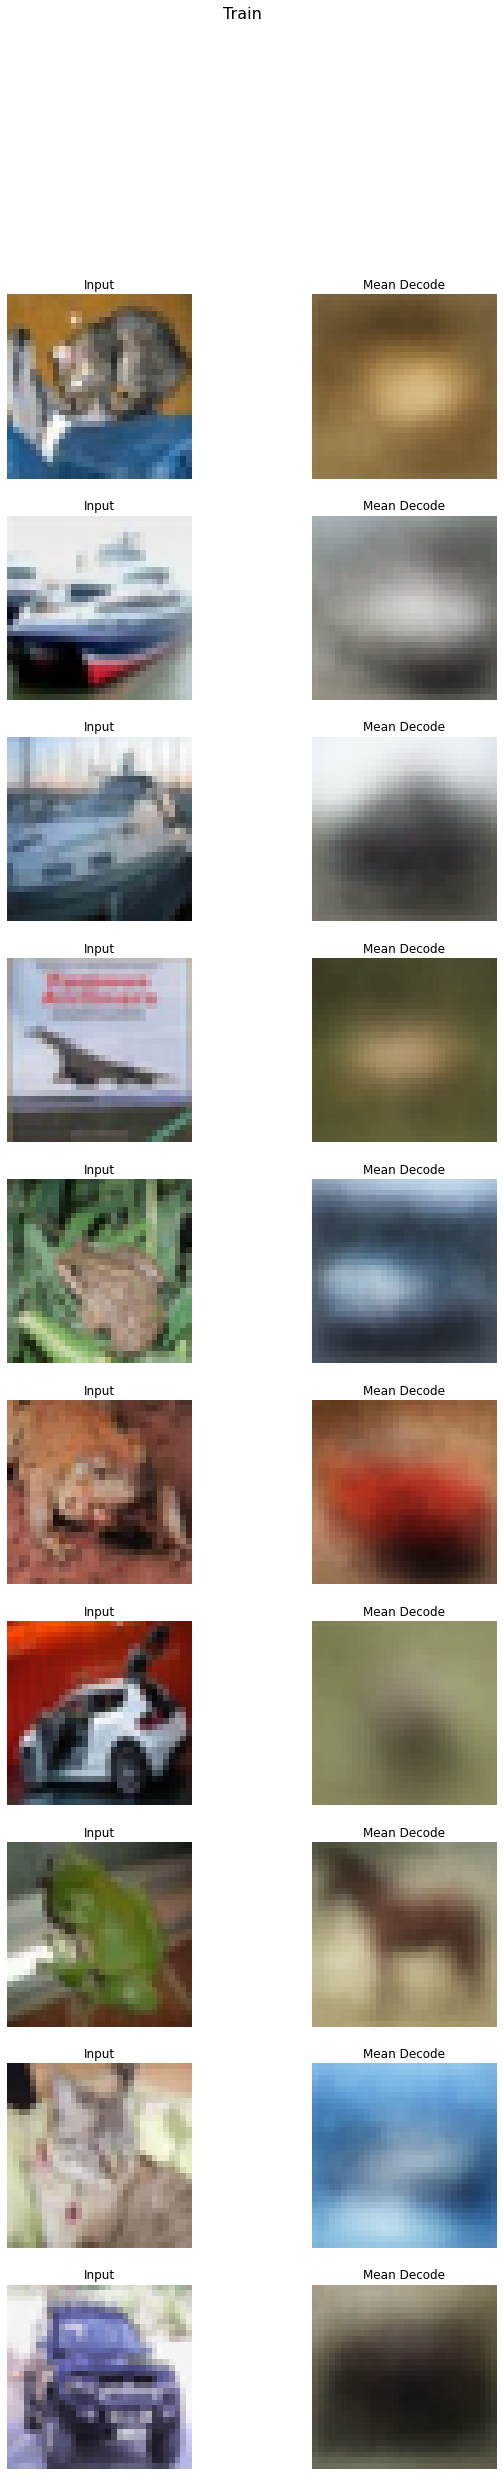

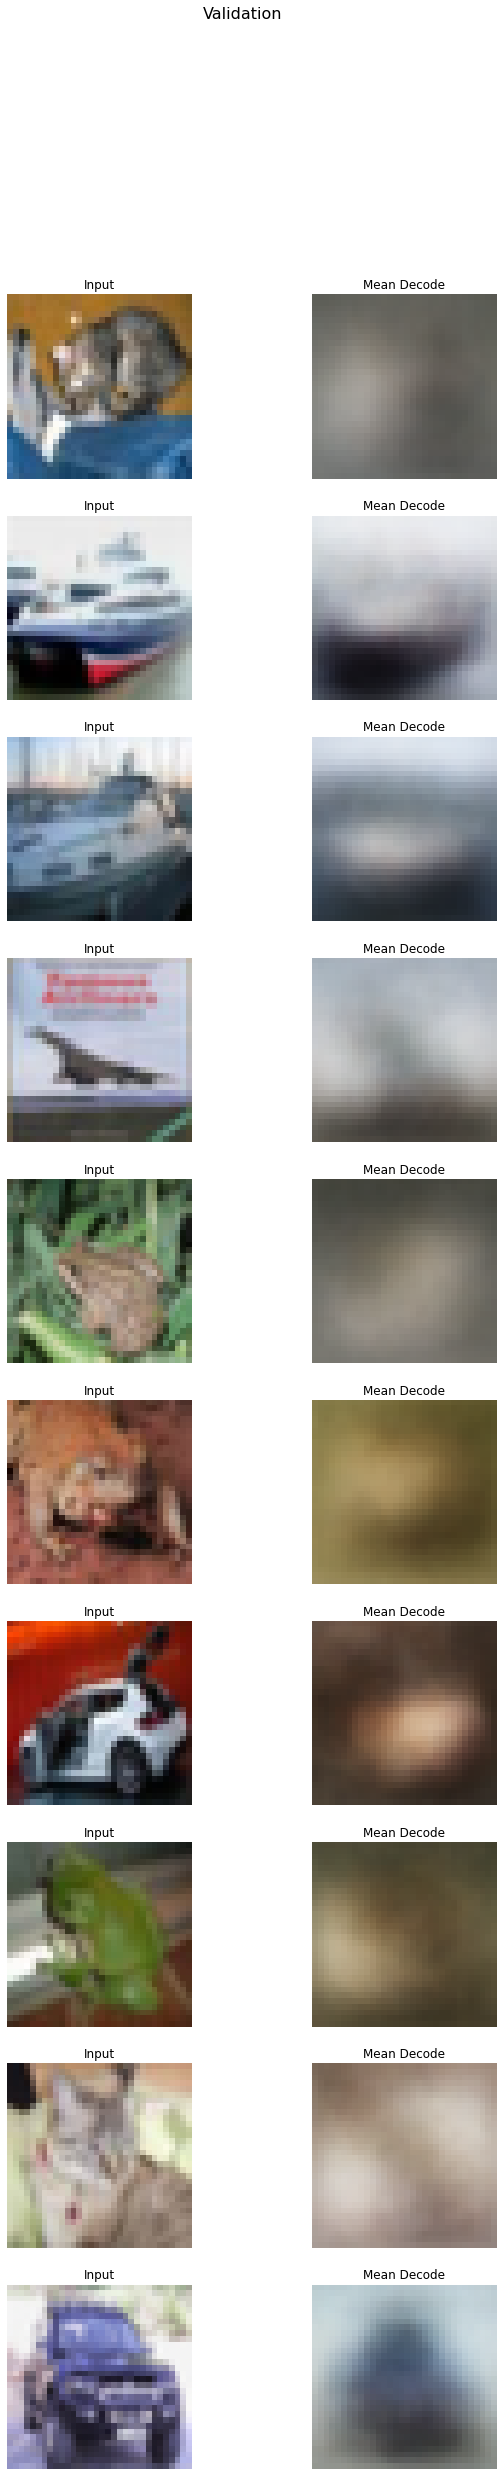

In [55]:

for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train_, x_test_], [y_train, y_test], ['Train', 'Validation'])):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

## Условные новые данные

**Задание 5.2** Реализовать условное моделирование из распределения $p(x \mid t, \text{label})$, сначала выбирая из априорного $p(t)$, а затем выбирая из вероятности $p(x \mid т, \text{метка})$.

In [56]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
n_samples = 50
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
# ...
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
#curr_labels.tolist()

In [57]:
_mean = tf.zeros([n_samples, original_dim], dtype=tf.float32)
_std =tf.ones([n_samples, original_dim], dtype=tf.float32)
t_samples = tf.random.normal([n_samples, latent_dim], mean=0, stddev=1, dtype=tf.float32)
curr_labels_tensor = tf.convert_to_tensor(curr_labels.tolist())
cond_sampled_im_mean = decoder2(tf.concat([t_samples, curr_labels_tensor],1))

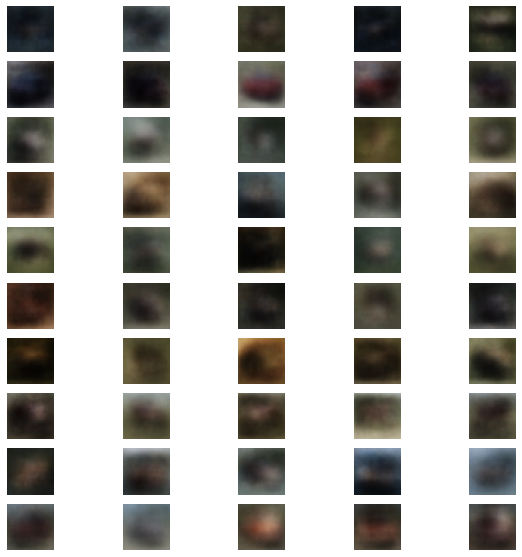

In [58]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :original_dim].reshape(32, 32, 3))
        ax.axis('off')
        global_idx += 1
plt.show()

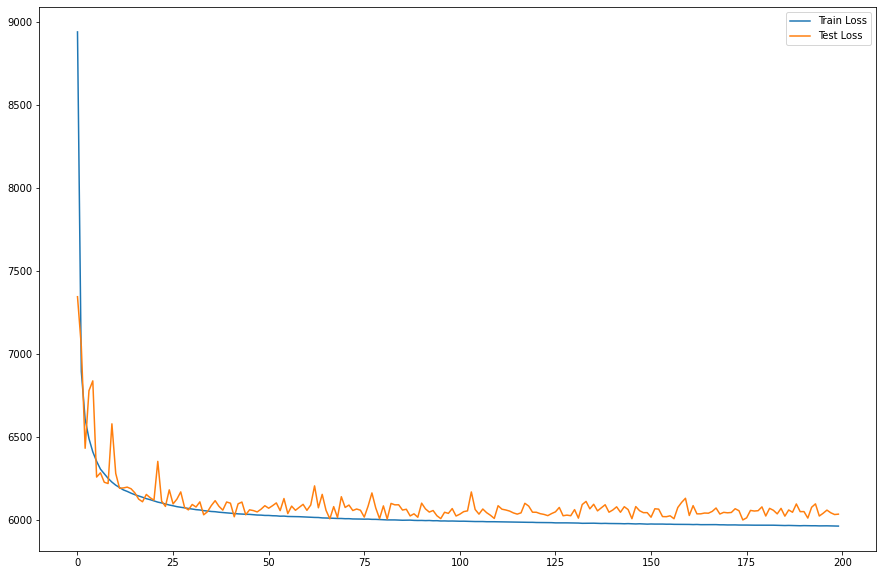

In [60]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss = hist.history['loss']

plt.plot(train_loss, label = 'Train Loss')


test_loss = hist.history['val_loss']

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


**Обязательная часть**
* Повторить задание 1-4 для смеси распределений Гаусса (см. лекцию). Добавить раннюю остановку (early stopping)
* Получить выражение для VLB (Задание 1)
* Изучить влияние параметров на качество восстановления (Поварьировать параметры обучения, структуру сетей и пр.) 

**Дополнительно**
* Повторить задание 5
* Изучить влияние параметров на качество восстановления (Поварьировать параметры обучения, структуру сетей и пр.) 
* Реализовать для 1-5 сверточные слои в нейронной сети. Проанализировать результат.